<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModelModCoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 125 (delta 50), reused 16 (delta 2), pack-reused 0
Receiving objects: 100% (125/125), 1.99 MiB | 7.30 MiB/s, done.
Resolving deltas: 100% (50/50), done.
project  sample_data
MainModel.ipynb		     MainModelOneHotMethodSoftMax.ipynb
MainModelKeras.ipynb	     MainModelWithSingleBERTraining.ipynb
MainModelKerasOneHot.ipynb   README.md
MainModelModCoding.ipynb     util.py
MainModelOneHotMethod.ipynb
     |████████████████████████████████| 1.1MB 2.5MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=fa0163c5b3e104db5fc9953d28d7bb7199c411cdb696ef787bb2e4f770c3f05e
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |████████████████████████████████| 51kB 1.5MB/s 


In [3]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [5]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [6]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 1 1 ... 1 1 0]
 [0 0 1 ... 1 0 1]
 [0 0 1 ... 1 0 0]
 ...
 [1 0 1 ... 0 0 1]
 [1 0 1 ... 0 1 1]
 [1 0 0 ... 0 1 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [7]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 2.28s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 4.34s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 6.13s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 7.83s
SNR: 0.000:
 -> BER: 0.61
 -> Total Time: 20.58s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.59s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.99s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.37s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.98s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 14.92s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.20s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.35s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.58s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.71s
SNR: 1.000:
 -> BER: 0.42
 -> Total Time: 11.85s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 2.00s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [8]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.68s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.34s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.77s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.47s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 16.25s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.33s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.70s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.04s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.32s
SNR: 0.500:
 -> BER: 0.50
 -> Total Time: 13.39s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.28s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.33s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.42s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.61s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 11.63s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.82s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.81s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [9]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.58s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.11s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.82s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.37s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 15.89s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.32s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.53s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.91s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.28s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 13.03s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.18s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.45s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.58s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.88s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 12.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.09s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.93s
SNR: 1.500 - Iter: 750 - Last 250.0 it

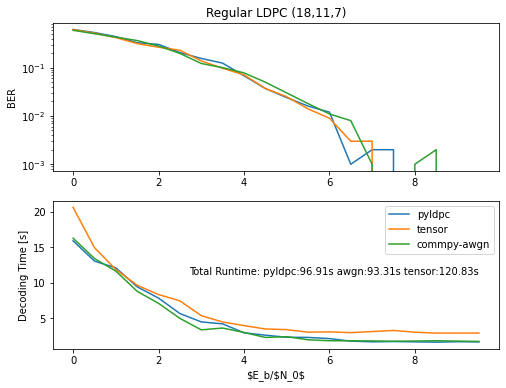

In [10]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [36]:
# Define Model 

# input_message_length is initialized by ldpc encoder
CHANNEL_SIZE=2
input_message_length = 4
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))

  #x = tf.sqrt(tf.reduce_sum(tf.square(layer_1), axis=1))
  #x = tf.reshape (x, (-1,1))
  #layer_2 = layer_1 / x

  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

#input_channel_x = tf.placeholder("float32", [None, 3], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x
def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
rms_optimizer = tf.train.AdamOptimizer(learning_rate=0.00007).minimize (loss1)
rms_optimizer1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

input_message_length= 4


In [38]:
batch_size = 50
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 50
outer_ephocs = 1
display_step = epochs/2
num_of_batches = len(training_input_message) / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1

for oe in range(outer_ephocs):
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (7)
    print ("Training for SNR=", snr, " sigma=", sigma) 
    if (snr < 6): opt = rms_optimizer1
    else : opt = rms_optimizer 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if (l < 0.5): lrate = 0.001
        if (l < 0.25): lrate = 0.00001
        if (l < 0.1): lrate = 0.000001
        if (l < 0.07): lrate = 0.0000001
        if j % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))

Streaming output truncated to the last 5000 lines.
Step 25100: Minibatch Loss: 0.000682
Step 25125: Minibatch Loss: 0.000678
Step 25150: Minibatch Loss: 0.000677
Step 24975: Minibatch Loss: 0.000674
Step 25000: Minibatch Loss: 0.000672
Step 25025: Minibatch Loss: 0.000675
Step 25050: Minibatch Loss: 0.000668
Step 25075: Minibatch Loss: 0.000669
Step 25100: Minibatch Loss: 0.000668
Step 25125: Minibatch Loss: 0.000665
Step 25150: Minibatch Loss: 0.000663
Step 24975: Minibatch Loss: 0.000662
Step 25000: Minibatch Loss: 0.000660
Step 25025: Minibatch Loss: 0.000662
Step 25050: Minibatch Loss: 0.000657
Step 25075: Minibatch Loss: 0.000657
Step 25100: Minibatch Loss: 0.000655
Step 25125: Minibatch Loss: 0.000654
Step 25150: Minibatch Loss: 0.000652
Step 24975: Minibatch Loss: 0.000650
Step 25000: Minibatch Loss: 0.000648
Step 25025: Minibatch Loss: 0.000650
Step 25050: Minibatch Loss: 0.000644
Step 25075: Minibatch Loss: 0.000646
Step 25100: Minibatch Loss: 0.000644
Step 25125: Minibatch Lo

In [13]:
#a = [[1,2],[3,4]]
#x=a/numpy.sqrt(numpy.sum(numpy.square(a),axis=1).reshape([2,1]))
#print (x)
#print (1/numpy.sqrt(5))
#print (x[0][0]**2+x[0][1]**2)

#input_channel_x = tf.placeholder("float32", [None, 2], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x

#ans=train_sess.run ([l], feed_dict={input_channel_x:a})
#print (ans)

#print (ans[0][0]**2+ans[0][1]**2)

In [39]:
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[0 1 1 1]
 [0 0 1 1]
 [1 0 0 0]
 ...
 [0 1 1 1]
 [1 1 0 0]
 [1 1 0 0]]
10000


In [41]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 10
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_x = []
channel_y = []
channel_n_x = []
channel_n_y = []

for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    channel_x.append(encoded_message[0][0][0])
    channel_y.append(encoded_message[0][0][1])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_n_x.append(awgn_channel_output_message[0][0])
    channel_n_y.append(awgn_channel_output_message[0][1])
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.58s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.86s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.13s
SNR: 0.000:
 -> BER: 0.08
 -> Total Time: 2.85s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.29s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.58s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.86s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.15s
SNR: 0.500:
 -> BER: 0.07
 -> Total Time: 2.89s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.84s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.13s
SNR: 1.000:
 -> BER: 0.04
 -> Total Time: 2.82s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.29s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

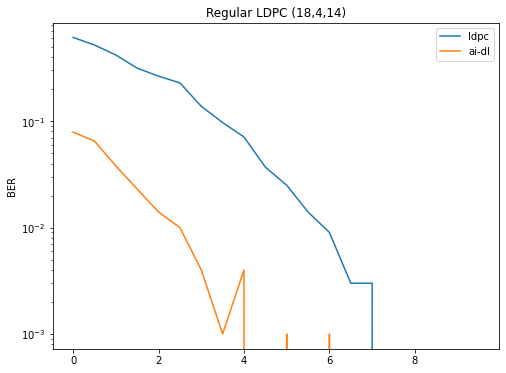

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

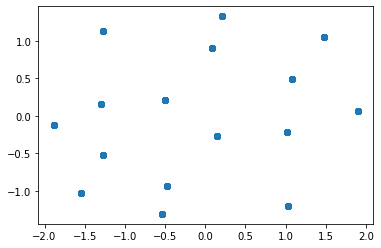

In [43]:
import matplotlib.pyplot as plt


plt.scatter(channel_x, channel_y)

plt.show()

In [44]:
print(channel_x)
print(channel_y)
print (channel_x[1]**2+channel_y[1]**2)

[-0.54126686, -1.2918314, 1.0822587, 1.9021448, -1.885939, -0.4720896, -1.885939, 1.9021448, 0.081711024, 0.20867208, -0.49499297, 1.4782284, 1.0230972, -1.2918314, -1.5505277, -1.2737689, -1.2675815, 1.9021448, 0.20867208, -0.49499297, -1.2918314, 1.9021448, 1.0230972, 1.4782284, 1.0271245, -1.885939, 1.9021448, -1.2675815, -1.5505277, 0.20867208, 0.081711024, -1.5505277, -1.5505277, -1.5505277, -1.5505277, -1.2918314, 0.14956635, -0.54126686, -1.2675815, 1.4782284, -1.885939, -0.54126686, -1.2737689, 1.9021448, 1.0822587, -0.49499297, -1.885939, -0.4720896, -0.4720896, -1.2675815, -1.885939, -0.4720896, -0.49499297, 1.9021448, -1.2675815, -0.54126686, -0.49499297, 0.20867208, -1.2675815, 1.0822587, -1.5505277, 0.081711024, 0.20867208, 1.0230972, 1.0230972, -0.54126686, 1.9021448, 1.0271245, -0.4720896, -0.54126686, -1.2918314, 1.4782284, 0.20867208, 1.0230972, -1.5505277, -1.2675815, -1.2737689, 0.081711024, 1.0822587, -0.4720896, -1.2918314, -1.885939, 0.081711024, -0.4720896, -0.49

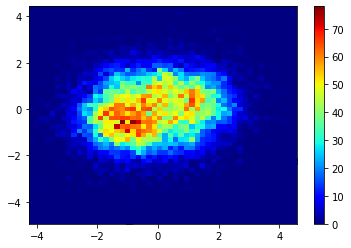

In [47]:
import matplotlib.pyplot as plt

plt.scatter(channel_n_x, channel_n_y)
plt.hist2d(channel_n_x, channel_n_y, (50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [20]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))


In [21]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.56s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.83s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.10s
SNR: 0.000:
 -> BER: 0.77
 -> Total Time: 2.75s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.56s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.85s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.13s
SNR: 0.500:
 -> BER: 0.77
 -> Total Time: 2.83s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.56s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.84s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.12s
SNR: 1.000:
 -> BER: 0.73
 -> Total Time: 2.79s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.55s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

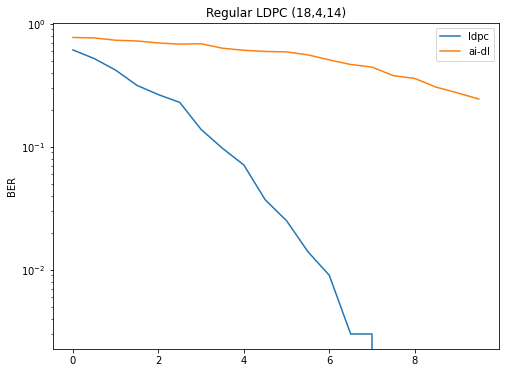

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()